In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm

In [26]:
def set_seed():
    np.random.seed(427)

In [27]:
def simulate_sabr(T, n_steps, F0, alpha_sabr0, beta, rho, nu):
    """
    Simulates a SABR model path using Euler discretization.

    Parameters:
    - T: Total time horizon.
    - n_steps: Number of time steps.
    - F0: Initial forward price.
    - alpha_sabr0: Initial SABR volatility.
    - beta: Elasticity parameter (0 <= beta <= 1).
    - rho: Correlation between price and volatility.
    - nu: Volatility of volatility.

    Returns:
    - t: Time grid.
    - F: Simulated price path.
    - alpha_sabr: Simulated volatility path.
    """
    dt = T / n_steps
    t = np.linspace(0, T, n_steps)
    F = np.zeros(n_steps)
    alpha_sabr = np.zeros(n_steps)
    F[0] = F0
    alpha_sabr[0] = alpha_sabr0
    
    # Generate correlated Brownian motions
    dW1 = np.random.normal(0, np.sqrt(dt), n_steps)
    dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), n_steps)
    
    for i in range(1, n_steps):
        # Prevent division by zero when beta < 1
        if F[i-1] < 1e-8:
            F[i-1] = 1e-8
            
        # Update volatility
        alpha_sabr[i] = alpha_sabr[i-1] + nu * alpha_sabr[i-1] * dW2[i-1]
        alpha_sabr[i] = max(alpha_sabr[i], 1e-6)  # Avoid negative volatility
        
        # Update forward price
        dF = alpha_sabr[i-1] * (F[i-1] ** beta) * dW1[i-1]
        F[i] = F[i-1] + dF
        
    return t, F, alpha_sabr

In [ ]:
def sabr_implied_vol(S,K, T, vol, beta, rho,volvol):

    """
    Computes the SABR model implied volatility approximation.

    Parameters:
    S : Current stock price (underlying forward price).
    K : Strike price.
    T : Time to maturity (in years).
    vol : Initial volatility (ATM volatility).
    beta : CEV exponent (controls skew).
    rho : Correlation between asset price and volatility.
    volvol : Volatility of volatility.

    Returns:
    SABR model implied volatility.
    """
     
    r = 0
    q = 0

    F = S * np.exp((r - q) * T)
    x = (F * K) ** ((1 - beta) / 2)
    y = (1 - beta) * np.log(F / K)
    A = vol / (x * (1 + y * y / 24 + y * y * y * y / 1920))
    B = 1 + T * (
        ((1 - beta) ** 2) * (vol * vol) / (24 * x * x)
        + rho * beta * volvol * vol / (4 * x)
        + volvol * volvol * (2 - 3 * rho * rho) / 24
    )
    Phi = (volvol * x / vol) * np.log(F / K)
    Chi = np.log((np.sqrt(1 - 2 * rho * Phi + Phi * Phi) + Phi - rho) / (1 - rho))

    SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)

    return SABRIV 

def bs_call(iv, T, S, K):

    """
    Computes the Black-Scholes price of a European call option.

    Parameters:
    iv : Implied volatility.
    T : Time to maturity.
    S : Current stock price.
    K : Strike price.

    Returns:
    Black-Scholes call option price.
    """

    r = 0
    q = 0
    d1 = (np.log(S / K) + (r - q + iv * iv / 2) * T) / (iv * np.sqrt(T))
    d2 = d1 - iv * np.sqrt(T)
    bs_price = S * np.exp(-q * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return bs_price


def bs_delta(sigma, T, S, K, r):
    
    """
    Computes the Black-Scholes delta of a European call option.

    Parameters:
    sigma : Implied volatility.
    T : Time to maturity.
    S : Current stock price.
    K : Strike price.
    r : Risk-free rate (default is 0).

    Returns:
    Black-Scholes call option delta.
    """

    r=0
    q=0
    iv = sigma
    d1 = (np.log(S / K) + (r - q + iv * iv / 2) * T) / (iv * np.sqrt(T))
    bs_delta = np.exp(-q * T) * norm.cdf(d1)
    return bs_delta

In [ ]:
def sabr_delta(sigma, T, S, K, beta, volvol, rho):

    """
    Computes the SABR model delta for a European call option.

    Parameters:
    sigma : Initial volatility (ATM volatility).
    T : Time to maturity.
    S : Current stock price.
    K : Strike price.
    beta : CEV exponent (controls skew).
    volvol : Volatility of volatility.
    rho : Correlation between asset price and volatility.

    Returns:
    SABR delta.
    """

    r= 0
    q= 0
    # Compute SABR-implied volatility
    sabr_iv = sabr_implied_vol(S, K, T,sigma, beta, rho, volvol)
    ds = 1e-6 * S
    dsigma = 1e-6 * sigma
    dsigma_ds = (sabr_implied_vol(S+ds, K, T,sigma, beta, rho, volvol)- sabr_implied_vol(S-ds, K, T,sigma, beta, rho, volvol)) / ds / 2
    d = (np.log(S/K)+0.5*sabr_iv**2*T) / (sabr_iv * np.sqrt(T))
    return norm.cdf(d) + np.sqrt(T) * norm.pdf(d) * (dsigma_ds)


def sabr_barlette_delta(sigma, T, S, K, beta, volvol, rho):

    """
    Computes the Barlett-adjusted SABR delta for a European call option.

    Parameters:
    sigma : Initial volatility (ATM volatility).
    T : Time to maturity.
    S : Current stock price.
    K : Strike price.
    beta : CEV exponent (controls skew).
    volvol : Volatility of volatility.
    rho : Correlation between asset price and volatility.

    Returns:
    Barlett-adjusted SABR delta.
    """

    r = 0
    q = 0
    sabr_iv = sabr_implied_vol(S, K, T,sigma, beta, rho, volvol)
    ds = 1e-6 * S
    dsigma = 1e-6 * sigma
    dsigma_ds = (sabr_implied_vol(S+ds, K, T,sigma, beta, rho, volvol) - sabr_implied_vol(S-ds, K, T,sigma, beta, rho, volvol)) / ds / 2
    dsigma_dsigma0 = (sabr_implied_vol(S, K, T,sigma+dsigma, beta, rho, volvol) - sabr_implied_vol(S, K, T,sigma-dsigma, beta, rho, volvol)) / dsigma / 2
    d = (np.log(S/K)+0.5*sabr_iv**2*T) / (sabr_iv * np.sqrt(T))
    return norm.cdf(d) + np.sqrt(T) * norm.pdf(d) * (dsigma_ds+dsigma_dsigma0*rho*volvol/(S**beta))

In [ ]:
def sabr_call_price(F, K, T, r, alpha_sabr, beta, rho, nu):
    """
    Computes the European call option price under the SABR model.

    Parameters:
    - F: Forward price.
    - K: Strike price.
    - T: Time to maturity.
    - r: Risk-free rate.
    - alpha_sabr, beta, rho, nu: SABR model parameters.

    Returns:
    - price: Call option price.
    """
    vol = sabr_implied_vol(F, K, T, alpha_sabr, beta, rho, nu)
    #print(vol)
    d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    price = np.exp(-r * T) * (F * norm.cdf(d1) - K * norm.cdf(d2))
    #delta = np.exp(-r * T) * norm.cdf(d1)  # Forward Delta
    return price

In [ ]:
def simulate_observed_price(X, alpha, eta, L=1):
    
    P = np.zeros_like(X)
    P[0] = np.round(X[0] / alpha) * alpha
    change_indices = [0]

    for i in range(1, len(X)):
        
        upper_threshold = P[i-1] + alpha * (L - 0.5 + eta)
        lower_threshold = P[i-1] - alpha * (L - 0.5 + eta)
        
        if X[i] >= upper_threshold:
            P[i] = P[i-1] + L * alpha
            change_indices.append(i)
        elif X[i] <= lower_threshold:
            P[i] = P[i-1] - L * alpha
            change_indices.append(i)
        else:
            P[i] = P[i-1]
    
    return  X, P, change_indices

In [ ]:
def plot_uncertainty_zone_matplotlib(X,alpha, eta):
    set_seed()
    X, P, change_indices = simulate_observed_price(X,alpha,eta)
    fig, ax = plt.subplots(figsize=(24, 12))

    # Plot Efficient Price and Observed Price
    ax.plot(t, X, label="Efficient Price", color="blue", linewidth=1.5)
    ax.step(t, P, where="post", label="Observed Price", color="red", linestyle="--", linewidth=1.5)

    # Compute mid prices and uncertainty zone boundaries
    mid_prices = np.zeros_like(X)
    lower_bounds = np.zeros_like(X)
    upper_bounds = np.zeros_like(X)
    shaded_lower = np.full_like(X, np.nan)
    shaded_upper = np.full_like(X, np.nan)

    for i in range(len(X)):
        k = np.round(X[i] / alpha)  # Closest tick level
        mid_prices[i] = (k - 0.5) * alpha  # Mid price between two adjacent ticks
        lower_bounds[i] = mid_prices[i] - alpha * (eta)
        upper_bounds[i] = mid_prices[i] + alpha * (eta)

    # Add grid lines at mid prices, lower, and upper bounds
    all_mid_prices = np.unique(mid_prices)
    all_lower_bounds = np.unique(lower_bounds)
    all_upper_bounds = np.unique(upper_bounds)

    # Horizontal grid lines
    for level in all_mid_prices:
        ax.axhline(y=level, color="green", linestyle="-", linewidth=0.5, alpha=1)
    for level in all_lower_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=1)
    for level in all_upper_bounds:
        ax.axhline(y=level, color="orange", linestyle="-", linewidth=0.5, alpha=1)

    # Add shaded area for uncertainty zones
    for i in range(len(change_indices) - 1):
        start = change_indices[i]
        end = change_indices[i + 1]

        mid_price = mid_prices[start]
        lower = mid_price - alpha * eta
        upper = mid_price + alpha * eta+alpha

        ax.fill_between(t[start:end+1], lower, upper, color="gray", alpha=0.2, step="post",edgecolor="none")


    # Labels and title
    ax.set_xlabel("Time", fontsize=14)
    ax.set_ylabel("Price", fontsize=14)
    ax.set_title("Efficient vs Observed Price with Mid Price and Uncertainty Zone Grid", fontsize=16)
    ax.legend(fontsize=12)
    plt.savefig("UncertaintyZone.pdf",format = "pdf")

    # Show plot
    plt.show()

In [ ]:
SABR_PARAMS = {
    'F0': 100.0,        # Initial price (Forward price at time 0)
    'alpha0': 0.01,     # Initial volatility (ATM volatility)
    'beta': 1.0,        # Elasticity constant (0 ≤ beta ≤ 1, beta = 1 for Black model)
    'rho': 0.2,         # Correlation between price and volatility (-1 ≤ rho ≤ 1)
    'nu': 0.05,         # Volatility of volatility (volvol)
}

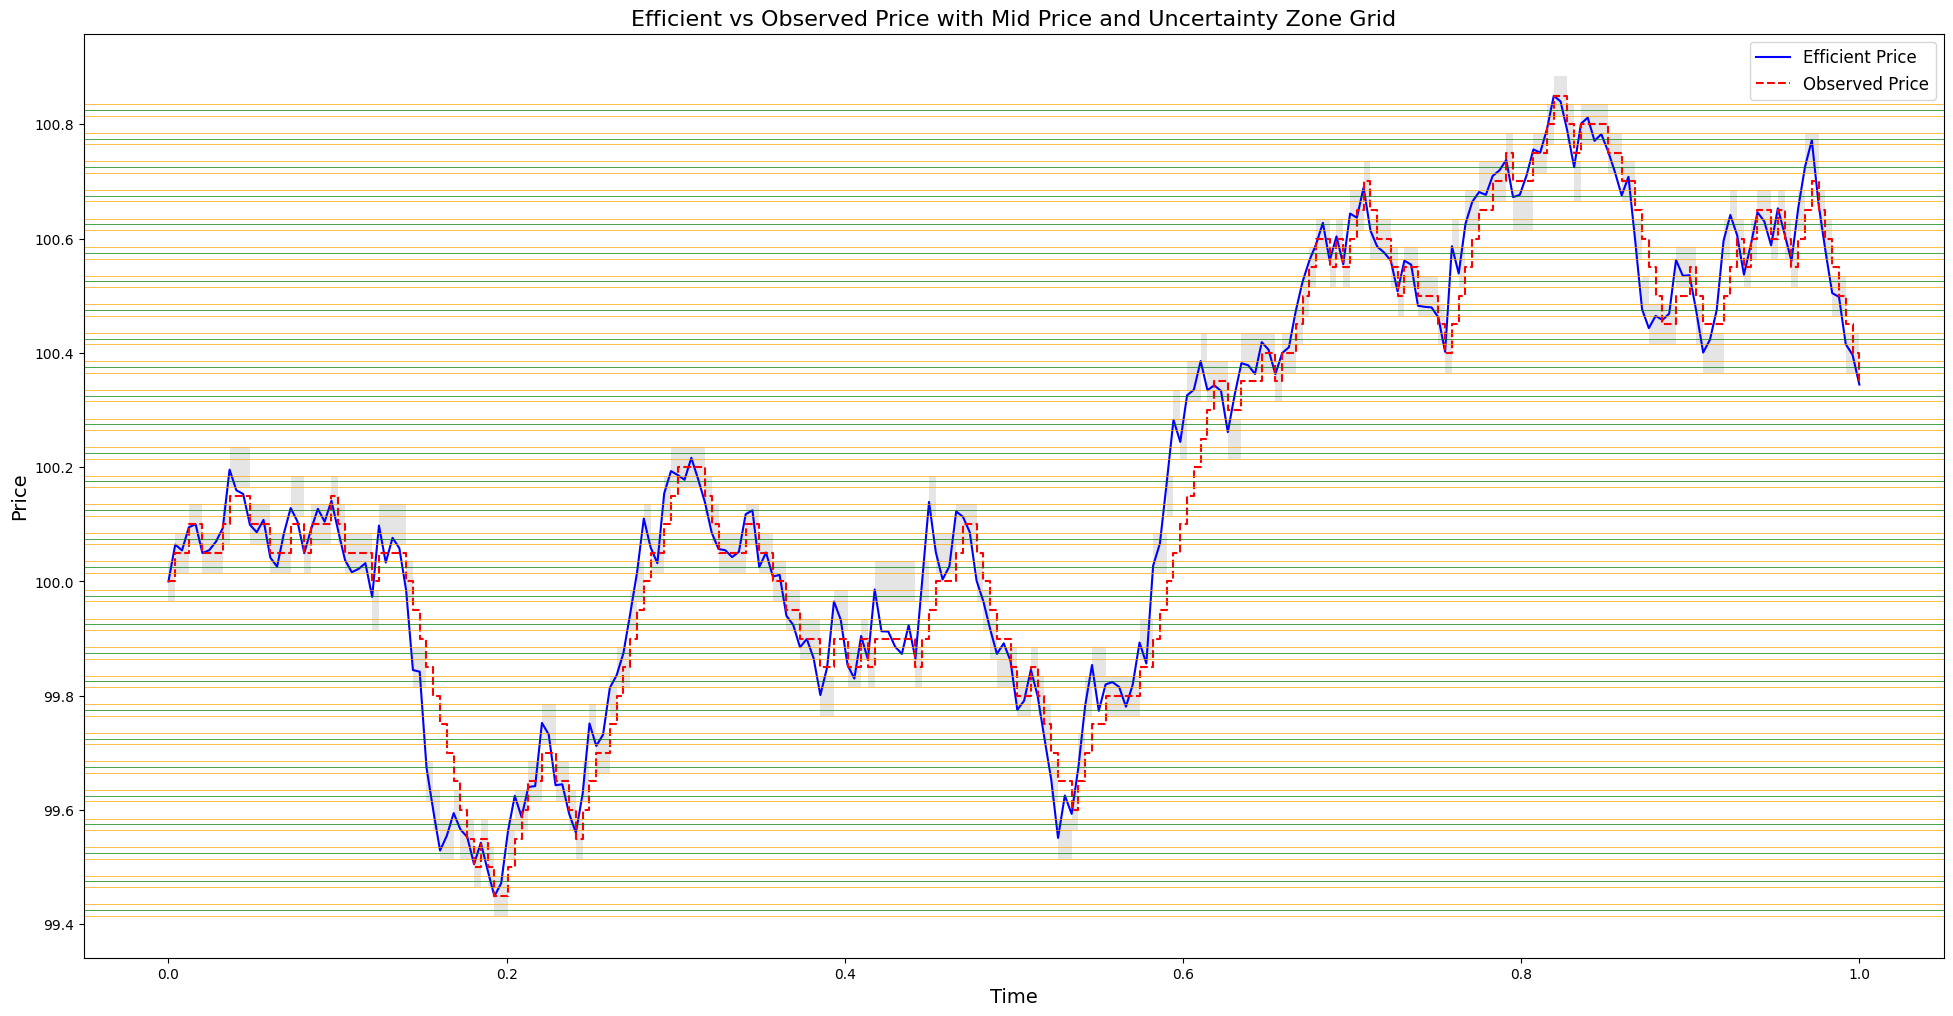

In [34]:
alpha = 0.05      # Tick size
eta = 0.2       # Uncertainty zone width
T = 1.0          # Time horizon
alpha_sabr0 = 0.01  # Volatility, sigma=0.01  5/np.sqrt(252)
F0 = 100      # Initial price
n_steps = 250   # Number of time steps
K = 100 # Strike
number_of_paths = 100 # For Monto Carlo
beta = 1
rho = 0.2
nu = 0.05
t, F, alpha1 = simulate_sabr(T, n_steps, F0, alpha_sabr0,beta,rho,nu)
plot_uncertainty_zone_matplotlib(F,alpha,eta)

In [35]:
eta = 0.05  # Uncertainty zone width
n_steps = 500

In [ ]:
def get_optimal_tau(X, alpha, eta):

    """
    Computes the optimal sampling times (tau) based on the efficient price X,
    adjusting when the price crosses the uncertainty zone.

    Parameters:
    X : The efficient price series.
    alpha : The minimum price tick size.
    eta : A noise parameter affecting price adjustments.

    Returns:
    tau : Indices where price updates occur.
    """

    tau = [0]  # Initialize the list of sampling times with the first index
    l = int(round(alpha**(-0.5)))  # Compute the step adjustment factor (rounded integer)
    current_zone = (X[0] // alpha) * alpha  # Determine the starting price zone
    threshold = alpha * (l - 0.5 + eta) # Compute the uncertainty threshold
    
    for i in range(1, len(X)):
        upper = current_zone + threshold # Upper boundary of the uncertainty zone
        lower = current_zone - threshold # Lower boundary of the uncertainty zone
        if X[i] > upper or X[i] < lower:
            tau.append(i)
            current_zone = (X[i] // alpha) * alpha # Reset the zone to the new price level
    return tau

In [37]:
def calculate_hedging_error(t, X, alpha_sabr_path, P, tau, K, params, use_efficient_price=True):

    """
    Computes the hedging error using the SABR model, tracking portfolio value 
    against the call option price.

    Parameters:
    t : Time vector.
    X : Efficient price series.
    alpha_sabr_path : Simulated SABR volatility path.
    P : Observed price series.
    tau : Indices where rebalancing occurs.
    K : Strike price.
    params : SABR model parameters (alpha, beta, rho, volvol).
    use_efficient_price : Whether to use efficient price (X) or observed price (P).

    Returns:
    The final hedging error, calculated as the difference between the 
           SABR call option value and the portfolio value at maturity.
    """

    T_total = t[-1]  # Total time horizon
    portfolio = np.zeros(len(tau))  # Initialize portfolio values
    positions = np.zeros(len(tau))  # Store delta hedging positions
    calls = np.zeros(len(tau))  # Store SABR call option prices
    
    
    # Initial Call Option Price
    calls[0]= sabr_call_price(
        X[tau[0]], K, T_total - t[tau[0]], 0,
        params['alpha_sabr0'], params['beta'],
        params['rho'], params['nu']
    )
    # Initial Hedging Position (Barlett-adjusted SABR delta)
    positions[0] = sabr_barlette_delta(
        params['alpha_sabr0'],T_total - t[tau[0]],
        X[tau[0]],K,params['beta'],
        params['nu'],params['rho']
        )
    
    # Initialize portfolio with the initial call price
    portfolio[0] = calls[0]
    
    for j in range(1, len(tau)):
        # Get current SABR volatility parameter
        alpha_sabr = alpha_sabr_path[tau[j]]
        
        # Compute price change (with or without volatility adjustment)
        if use_efficient_price:
            dF = X[tau[j]] - X[tau[j-1]]
            dalpha = alpha_sabr - alpha_sabr_path[tau[j-1]]
        else:
            dF = P[tau[j]] - P[tau[j-1]]
            dalpha = 0  
            
        portfolio[j] = portfolio[j-1] + positions[j-1] * (dF + 0.5*dalpha)  # 简化假设
        
        # Portfolio value update (simplified assumption)
        remaining_T = T_total - t[tau[j]]
         # Update Call Option Price using SABR model
        calls[j] = sabr_call_price(X[tau[j]], K, remaining_T, 0,alpha_sabr, params['beta'],params['rho'], params['nu'])
        # Update Hedging Position using Barlett-adjusted SABR Delta
        positions[j] = sabr_barlette_delta(
        alpha_sabr,T_total - t[tau[j]],
        X[tau[j]],K,params['beta'],
        params['nu'],params['rho']
        )

    plt.plot(t[tau], portfolio, label = 'Portfolio value at stopping time')
    plt.plot(t[tau], calls, label = 'Call option price at stopping time')
    
    return calls[-1] - portfolio[-1]

In [ ]:
def generate_observed_prices(X, tau, alpha):
    """
    Generates observed prices based on the exit times (tau), ensuring price updates 
    occur only at specific time steps.

    Parameters:
    X : The efficient price series.
    tau : Indices of exit times where price updates occur.
    alpha : Minimum price tick size.

    Returns:
    P : The observed price series.
    """
    P = np.zeros_like(X)
    current_p = None
    for i in range(len(X)):
        if i in tau:
            current_p = np.round(X[i] / alpha) * alpha # Round price to nearest tick size
        P[i] = current_p if current_p is not None else X[0] # Use the last observed price
    return P

In [39]:
sabr_call_price(100.1 ,100 ,1.0 ,0 ,0.01 ,1 ,0.2 ,0.05)

np.float64(0.45102286141631254)

In [40]:
sabr_implied_vol(100,100,1,0.01,1,0.05,0.2)

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_53048/2403508397.py:19: RuntimeWarning: invalid value encountered in scalar divide
  SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)


array(0.01003346)

In [41]:
bs_call(0.01003346,1,100,100)

np.float64(0.40027546227683786)

In [42]:
bs_call(0.04837420293443696,1,100,100)

np.float64(1.9296633340109963)

/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_53048/2403508397.py:19: RuntimeWarning: invalid value encountered in scalar divide
  SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)
/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_53048/2501987269.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_53048/386203342.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  d = (np.log(S/K)+0.5*sabr_iv**2*T) / (sabr_iv * np.sqrt(T))


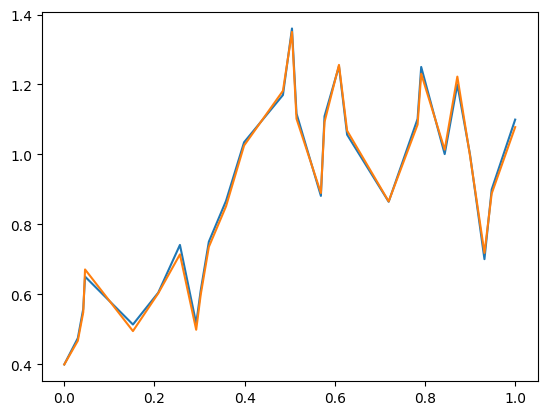

In [ ]:
error = [0,0,0]
for i in range(1):
    # Simulate SABR price path
    t, X, alpha_sabr_t = simulate_sabr(T, n_steps, F0, alpha_sabr0, beta, rho, nu)
    # Simulate observed price process
    _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta)
    tau_optimal = get_optimal_tau(X, alpha, eta)
    P_optimal = generate_observed_prices(X, tau_optimal, alpha)
    # Compute hedging errors for different strategies
    error[0] = calculate_hedging_error(t, X, alpha_sabr_t, P_optimal, tau_optimal, K, SABR_PARAMS, False)

In [44]:
error_1 = np.zeros(number_of_paths)  
error_2 = np.zeros(number_of_paths) 
error_3 = np.zeros(number_of_paths)

Processing Paths:   0%|          | 0/100 [00:00<?, ?it/s]/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_53048/2403508397.py:19: RuntimeWarning: invalid value encountered in scalar divide
  SABRIV = np.where(F == K, vol * B / (F ** (1 - beta)), A * B * Phi / Chi)
/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_53048/2501987269.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(F / K) + 0.5 * vol**2 * T) / (vol * np.sqrt(T))
/var/folders/9t/9j621j7x7jzc0wvhlbr8tcjh0000gn/T/ipykernel_53048/386203342.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  d = (np.log(S/K)+0.5*sabr_iv**2*T) / (sabr_iv * np.sqrt(T))
Processing Paths: 100%|██████████| 100/100 [00:31<00:00,  3.15it/s]


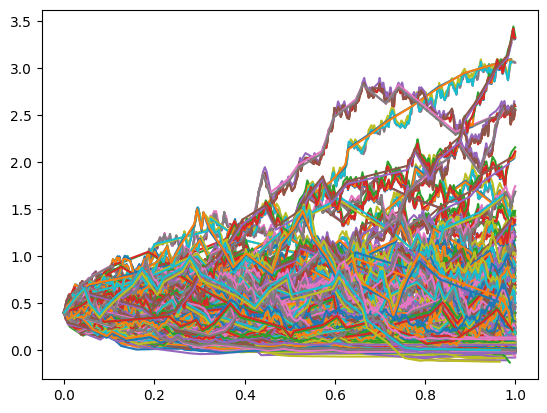

In [ ]:
from tqdm import tqdm

for i in tqdm(range(number_of_paths), desc="Processing Paths"):
    # Simulate SABR price path
    t, X, alpha_sabr_t = simulate_sabr(T, n_steps, F0, alpha_sabr0, beta, rho, nu)
    
    # Simulate observed price process
    _, P_fixed, tau_fixed = simulate_observed_price(X, alpha, eta)
    tau_optimal = get_optimal_tau(X, alpha, eta)
    P_optimal = generate_observed_prices(X, tau_optimal, alpha)
    
    # Compute hedging errors for different strategies
    error_1[i] = calculate_hedging_error(t, X, alpha_sabr_t, X, np.arange(len(t)),K, SABR_PARAMS, True)
    error_2[i] = calculate_hedging_error(t, X, alpha_sabr_t, P_fixed, tau_fixed, K, SABR_PARAMS, False)
    error_3[i] = calculate_hedging_error(t, X, alpha_sabr_t, P_optimal, tau_optimal, K, SABR_PARAMS, False)


In [46]:
print(error_1.mean())
print(error_2.mean())
print(error_3.mean())
print(error_1.std())
print(error_2.std())
print(error_3.std())

0.0015565217733540717
-0.11771079710847482
0.01200025367948615
0.015942115326414874
0.049454242539935876
0.04749680527617213


In [47]:
error_2

array([-0.14805959, -0.07310512, -0.13410922, -0.11612413, -0.12006385,
       -0.16729716, -0.14532334, -0.13059284, -0.08668292, -0.09667655,
       -0.13028205, -0.1679632 , -0.19493839, -0.03375296, -0.18064038,
       -0.10046108, -0.03645319, -0.04637309, -0.1664104 , -0.07899502,
       -0.04808026, -0.09377236, -0.18389757, -0.18108514, -0.11148286,
       -0.02357509, -0.07112236, -0.10930864, -0.15082724, -0.10385945,
       -0.08987482, -0.03277544, -0.11475493, -0.20676864, -0.16226291,
       -0.1301209 , -0.16970841, -0.12575897, -0.16483048, -0.11810804,
       -0.03769402, -0.10840982, -0.1445848 , -0.05522851, -0.08810694,
       -0.22224985, -0.16336848, -0.17777293, -0.06834512, -0.16046894,
       -0.04438034, -0.05979644, -0.12098288, -0.18548461, -0.14283971,
       -0.16973774, -0.11495061, -0.07239067, -0.05876775, -0.06018023,
       -0.17963006, -0.0901747 , -0.1597963 , -0.14161674, -0.06430352,
       -0.14571243, -0.13076261, -0.15749755, -0.12786167, -0.16

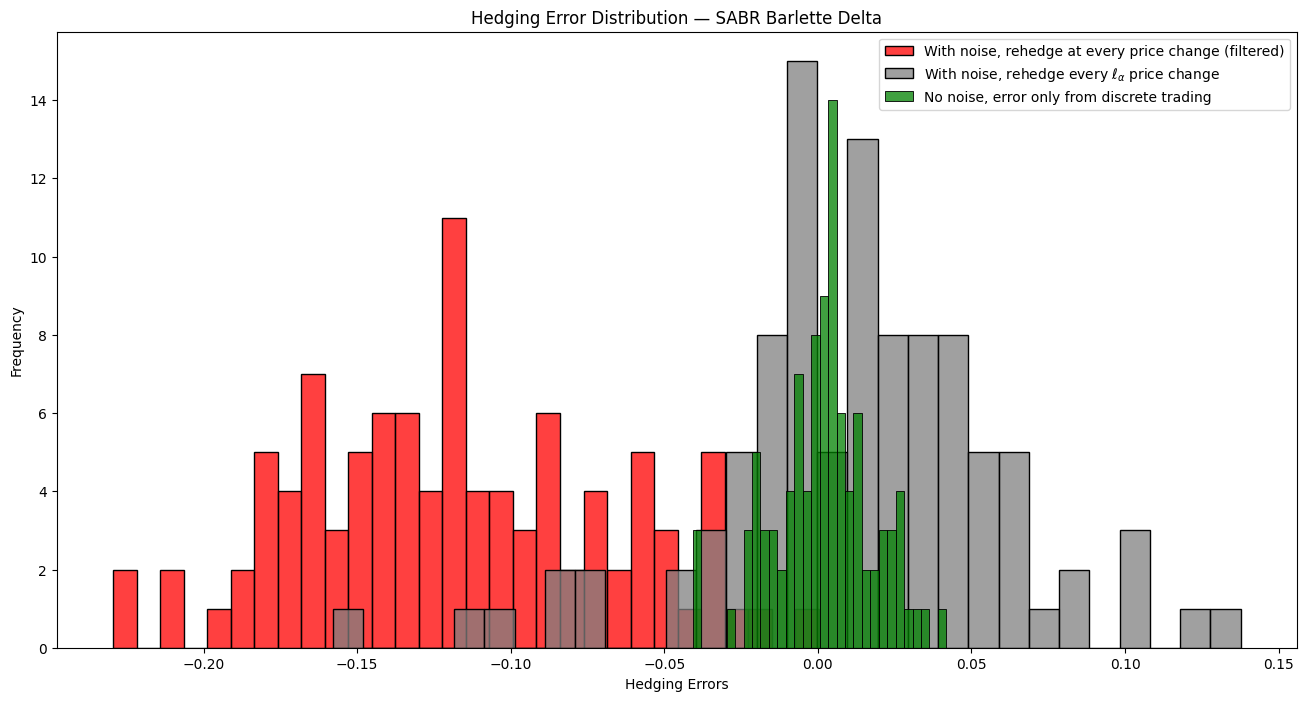

In [48]:
# Plot histogram
plt.figure(figsize=(16, 8))
sns.histplot(error_2, label="With noise, rehedge at every price change (filtered)", bins=30, color='red', stat='count', legend=True)
sns.histplot(error_3, label=r"With noise, rehedge every $\ell_\alpha$ price change", bins=30, color='grey', stat='count', legend=True)
sns.histplot(error_1, label="No noise, error only from discrete trading", bins=30, color='green', stat='count', legend=True)

# Labels and Title
plt.xlabel("Hedging Errors")
plt.ylabel("Frequency")
plt.title("Hedging Error Distribution — SABR Barlette Delta")
plt.legend()
plt.savefig("hedgingError__BD.pdf", format="pdf")

# Show plot
plt.show()
